In [1]:
%load_ext autoreload
%matplotlib inline
%autoreload 2

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import os
import sys
import pickle
import h5py

In [3]:
#sys.path.append("../..")
sys.path.append("..")

from WatChMaL.analysis.multi_plot_utils import multi_disp_learn_hist, multi_compute_roc, multi_plot_roc
from WatChMaL.analysis.comparison_utils import multi_get_masked_data, multi_collapse_test_output
from WatChMaL.analysis.performance_analysis_utils import remove_indices
from WatChMaL.analysis.performance_analysis_plot_utils import plot_fitqun_binned_performance, plot_momentum_binned_performance
from WatChMaL.analysis.performance_analysis_plot_utils import plot_true_momentum_binned_performance, plot_to_wall_binned_performance, plot_energy_binned_performance, plot_zenith_binned_performance, plot_azimuth_binned_performance
from WatChMaL.analysis.performance_analysis_plot_utils import plot_to_wall_binned_in_energy, plot_zenith_binned_in_azimuth, plot_azimuth_binned_in_zenith

In [4]:
############# define plotting params #############
c = plt.rcParams['axes.prop_cycle'].by_key()['color']
label_dict = {"$\gamma$":0, "$e$":1, "$\mu$":2, "$\pi^0$": 3}
inverse_label_dict = {0:"$\gamma$", 1:"$e$", 2:"$\mu$", 3: "$\pi^0$"}

# Define run locations

In [5]:
pointnet_locs = ['/project/rpp-blairt2k/jgao/WatChMaL/outputs/2022-05-04/07-08-28/outputs'] # e/gamma w/ mpmt
#                  '/project/rpp-blairt2k/jgao/WatChMaL/outputs/2021-08-11/05-48-21/outputs', # e/mu bad geometry
#                  '/project/rpp-blairt2k/jgao/WatChMaL/outputs/2021-12-18/11-59-40/outputs', # e/mu new data
#                  '/project/rpp-blairt2k/jgao/WatChMaL/outputs/2021-12-28/15-23-12/outputs'] # e/mu new w/o mpmt 
#                  '/project/rpp-blairt2k/jgao/WatChMaL/outputs/2021-12-14/15-12-03/outputs', # e/pi0 new data
#                  '/project/rpp-blairt2k/jgao/WatChMaL/outputs/2021-12-30/17-40-40/outputs'] # e/pi0 new w/o mpmt

fitqun_locs = ['/project/rpp-blairt2k/jgao/WatChMaL_analysis/fitqun_comparison/processed_fq_output_ROC_w_mPMT.npz']
#                '/project/rpp-blairt2k/jgao/WatChMaL_analysis/fitqun_comparison/processed_fq_output_ROC-badgeometry.npz',
#                '/project/rpp-blairt2k/jgao/WatChMaL_analysis/fitqun_comparison/processed_fq_output_ROC_w_mPMT.npz',
#                '/project/rpp-blairt2k/jgao/WatChMaL_analysis/fitqun_comparison/processed_fq_output_ROC_wo_mPMT.npz']

fitqun_files = [np.load(i, allow_pickle=True) for i in fitqun_locs]

pointnet_titles = [#'PointNet, Bad Geometry',
#                    'PointNet, w/ mPMTs',
                   'PointNet, w/ mPMTs']

fitqun_titles = ['FiTQun, w/ mPMTs']#'FiTQun, Bad Geometry', 
#                  'FiTQun, w/ mPMTs',
#                  'FiTQun, w/o mPMTs']

pointnet_linecolor = [#c[0], 
                      c[0]]
pointnet_linestyle = [#':', 
                      '-']

fitqun_linecolor = [c[3]]#c[3], c[3]]
fitqun_linestyle = ['-']#'-.', '-']

# Plot loss and accuracy curves for pointnet

In [101]:
# fig = multi_disp_learn_hist(resnet_locs, losslim=2.5, titles=resnet_titles, leg_font=15, title_font=15, xmax=20)

i:  0
Found training logs:  ['/project/rpp-blairt2k/jgao/WatChMaL/outputs/2022-05-04/07-08-28/outputs/log_train_2.csv', '/project/rpp-blairt2k/jgao/WatChMaL/outputs/2022-05-04/07-08-28/outputs/log_train_0.csv', '/project/rpp-blairt2k/jgao/WatChMaL/outputs/2022-05-04/07-08-28/outputs/log_train_3.csv', '/project/rpp-blairt2k/jgao/WatChMaL/outputs/2022-05-04/07-08-28/outputs/log_train_1.csv']


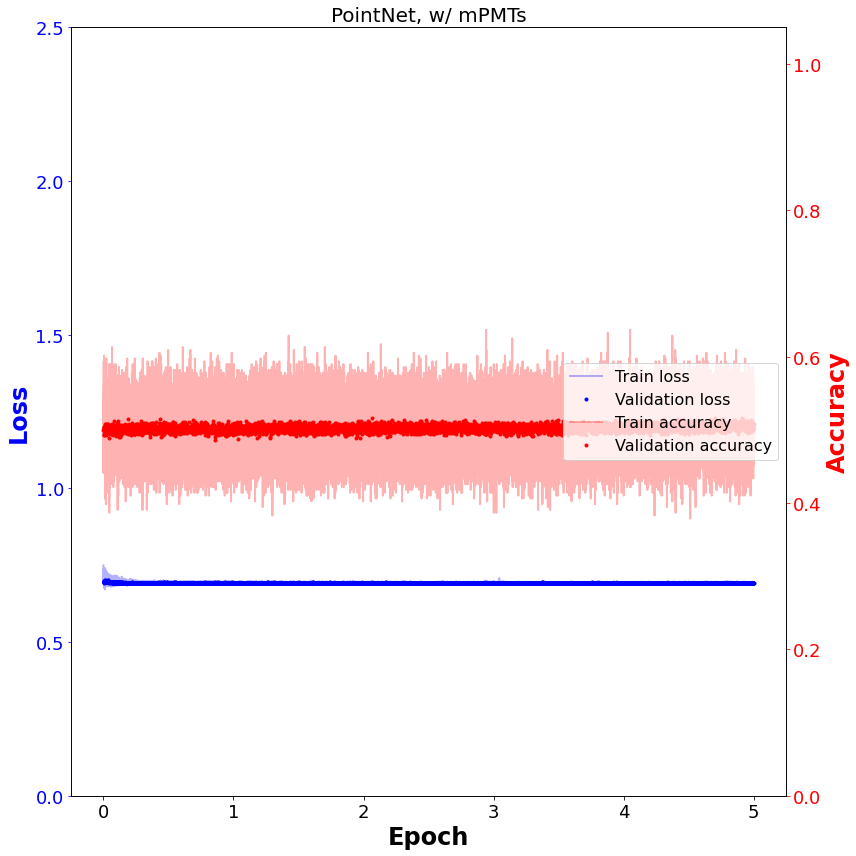

In [6]:
fig = multi_disp_learn_hist(pointnet_locs, losslim=2.5, titles=pointnet_titles, leg_font=15, title_font=15, xmax=40)

# Plot ROC curves for pointnet and fitqun

In [6]:
pointnets=[0]
fitquns=[0]

In [7]:
locs = [pointnet_locs[i] for i in pointnets]
titles = [pointnet_titles[i] for i in pointnets] + [fitqun_titles[i] for i in fitquns]
linecolor = [pointnet_linecolor[i] for i in pointnets] + [fitqun_linecolor[i] for i in fitquns]
linestyle = [pointnet_linestyle[i] for i in pointnets] + [fitqun_linestyle[i] for i in fitquns]

In [8]:
############# load HK hybrid ML testset result #############
HKHybrid_raw_output_softmax   = [np.load(loc + "/softmax.npy") for loc in locs]
HKHybrid_raw_actual_labels    = [np.load(loc + "/labels.npy") for loc in locs]

Construct my own cut index array to match the ML result with fitqun result (first 600 events of the first 400 files for each particle are selected, so the cut idxs array has to have the rest of the idxs).

In [10]:
# The following code block doesn't need to be run every time!
cut_test_idxs = np.array([], dtype=int)
for file in range(400):
    for evt in np.arange(600,3000):
        cut_test_idxs = np.append(cut_test_idxs, evt+3000*file)
cut_test_idxs = np.append(cut_test_idxs, cut_test_idxs+1200000)
np.savez('cut_ML_test_indices_to_match_fitqun.npz', cut_test_idxs=cut_test_idxs)

KeyboardInterrupt: 

In [9]:
cut_test_idxs_data = np.load('./cut_ML_test_indices_to_match_fitqun.npz', allow_pickle=True)
cut_test_idxs      = cut_test_idxs_data['cut_test_idxs']
cut_output_softmax = [remove_indices(HKHybrid_raw_output_softmax[0], cut_test_idxs)]
cut_actual_labels  = [remove_indices(HKHybrid_raw_actual_labels[0], cut_test_idxs)]

In [15]:
HKHybrid_raw_output_softmax[0][:,1]

array([0.5055584 , 0.5206096 , 0.48893973, ..., 0.50466347, 0.5176925 ,
       0.51912147], dtype=float32)

In [16]:
############# compute short tank multi e/mu ROC #############
fprs, tprs, thrs = multi_compute_roc(HKHybrid_raw_output_softmax, HKHybrid_raw_actual_labels,
                                     true_label=label_dict["$e$"], 
                                     false_label=label_dict["$\gamma$"])

In [15]:
fprs, tprs, thrs = [], [], []

In [17]:
############# add in fitqun data #############
# for i in fitquns:
#     fq_fpr_e = fitqun_files[i]['fq_fpr_e']
#     fq_tpr_e = fitqun_files[i]['fq_tpr_e']
#     fq_threshold_e = fitqun_files[i]['fq_threshold_e']

#     fprs.append(fq_fpr_e)
#     tprs.append(fq_tpr_e)
#     thrs.append(fq_threshold_e)
    
# fq_fpr_e_for_pi0 = fitqun_files[0]['fq_fpr_e_for_pi0']
# fq_tpr_e_for_pi0 = fitqun_files[0]['fq_tpr_e_for_pi0']
# fq_threshold_e_for_pi0 = fitqun_files[0]['fq_threshold_e_for_pi0']
# fprs.append(fq_fpr_e_for_pi0)
# tprs.append(fq_tpr_e_for_pi0)
# thrs.append(fq_threshold_e_for_pi0)

fq_fpr_e_for_g = fitqun_files[0]['fq_fpr_e_for_g']
fq_tpr_e_for_g = fitqun_files[0]['fq_tpr_e_for_g']
fq_threshold_e_for_g = fitqun_files[0]['fq_threshold_e_for_g']
fprs.append(fq_fpr_e_for_g)
tprs.append(fq_tpr_e_for_g)
thrs.append(fq_threshold_e_for_g)

[<AxesSubplot:>]
[<AxesSubplot:title={'center':'$e$ vs $\\gamma$ Rejection'}, xlabel='$e$ Signal Efficiency', ylabel='$\\gamma$ Background Rejection'>]


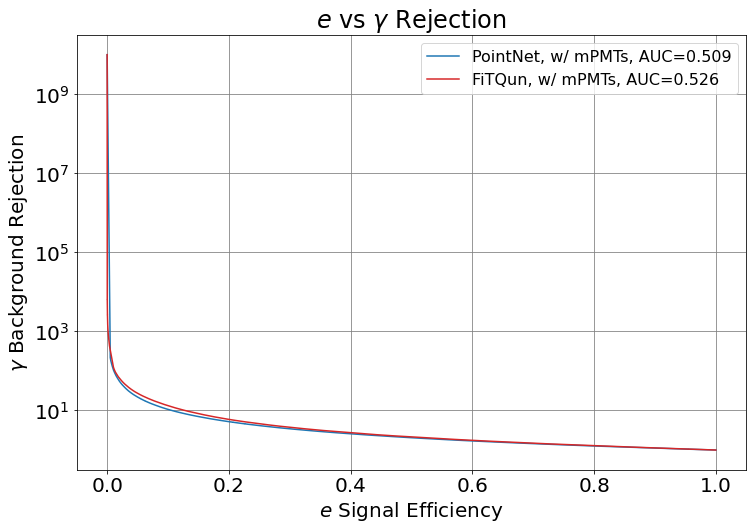

In [20]:
figs = multi_plot_roc(fprs, tprs, thrs, "$e$", "$\gamma$", 
                      fig_list=[1],linestyles=linestyle,linecolors=linecolor, 
                      plot_labels=titles, show=False)#,
                      #leg_loc='lower left')

[<AxesSubplot:>]


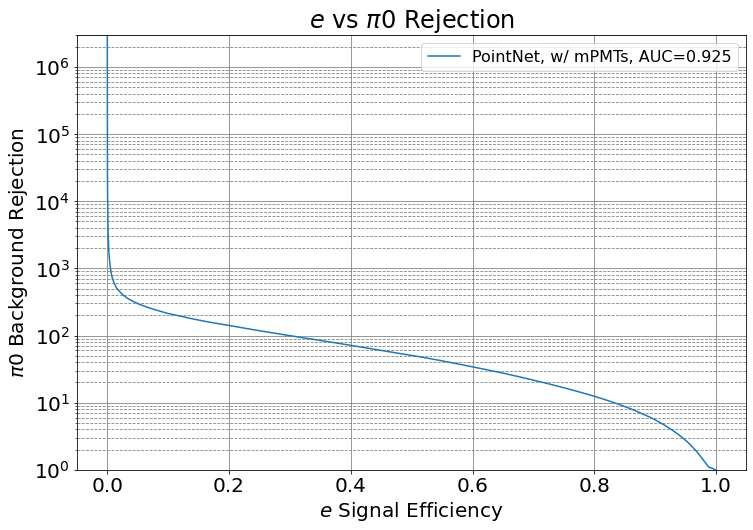

In [18]:
figs = multi_plot_roc(fprs, tprs, thrs, "$e$", "$\pi0$", 
                      fig_list=[1], ylims=[[1,3e6]], 
                      linestyles=linestyle,linecolors=linecolor, 
                      plot_labels=titles, show=False)
# plt.savefig("e-mu-PID.png", transparent=True)

# E-/Pi0 Separation ROC curve

In [18]:
fq_fpr_e_for_pi0 = fitqun_files[0]['fq_fpr_e_for_pi0']
fq_tpr_e_for_pi0 = fitqun_files[0]['fq_tpr_e_for_pi0']
fq_threshold_e_for_pi0 = fitqun_files[0]['fq_threshold_e_for_pi0']
fprs.append(fq_fpr_e_for_pi0)
tprs.append(fq_tpr_e_for_pi0)
thrs.append(fq_threshold_e_for_pi0)

[<AxesSubplot:>]
[<AxesSubplot:title={'center':'$e$ vs $\\pi^0$ Rejection'}, xlabel='$e$ Signal Efficiency', ylabel='$\\pi^0$ Background Rejection'>]


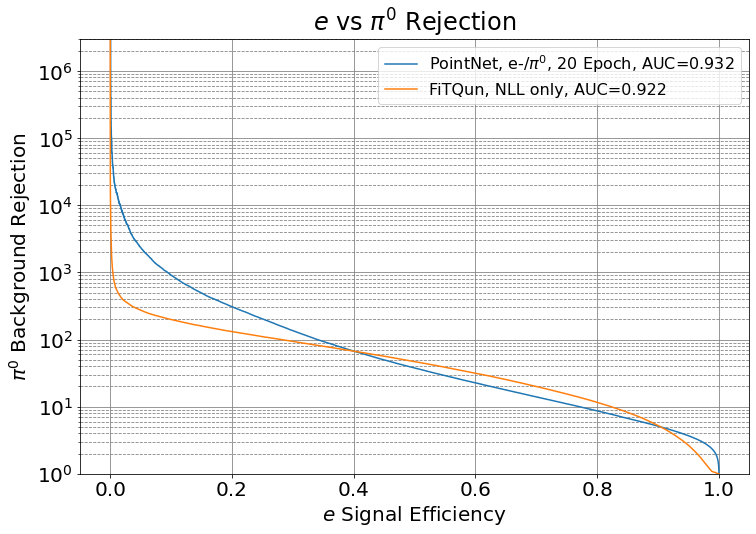

In [19]:
figs = multi_plot_roc(fprs, tprs, thrs, "$e$", "$\pi^0$", 
                      fig_list=[1], ylims=[[1,3e6]], 
                      linestyles=linestyle,linecolors=linecolor, 
                      plot_labels=titles, show=False)

# performance vs. initial energy, location, direction

Load raw h5 digihit data and indices to extract true momentum

In [9]:
fq_mom      = fitqun_files[0]['fq_mom']
fq_scores   = fitqun_files[0]['fq_scores']
fq_labels   = fitqun_files[0]['fq_labels']
scores_list = [HKHybrid_raw_output_softmax[0][:,1]/(HKHybrid_raw_output_softmax[0][:,0]+HKHybrid_raw_output_softmax[0][:,1]),  # pointnet scores
               fq_scores[:,1]]
labels_list = [HKHybrid_raw_actual_labels[0], fq_labels]
names       = ['PointNet, 20 epochs', 'FiTQun']
colors      = ['g', 'r']
fpr_rate    = 0.8

In [16]:
h5_data_path = "/project/rpp-blairt2k/machine_learning/data/HKHybrid/numpy/HKHybrid_e-gamma_E0to1000MeV_unif-pos-R3240-y3287cm_4pi-dir_6Mevts_w_mPMT.hdf5"
h5_data      = h5py.File(h5_data_path, "r")

energyies    = np.array(h5_data['energies'])
angles       = np.array(h5_data['angles'])
positions    = np.array(h5_data['positions'])
labels       = np.array(h5_data['labels'])

In [14]:
idxs_path = "/project/rpp-blairt2k/machine_learning/data/HKHybrid/numpy/HKHybrid_e-gamma_E0to1000MeV_unif-pos-R3240-y3287cm_4pi-dir_idxs_w_mPMT.npz"
idxs_data = np.load(idxs_path, allow_pickle=True)
test_idxs = idxs_data['test_idxs']

# only need test set truth info and trim to FiTQun result length
test_energies  = remove_indices(energyies[test_idxs], cut_test_idxs)
test_angles    = remove_indices(angles[test_idxs], cut_test_idxs)
test_positions = remove_indices(positions[test_idxs], cut_test_idxs)
test_labels    = remove_indices(labels[test_idxs], cut_test_idxs)

test_zenith_angles  = test_angles[:, 0]
test_azimuth_angles = test_angles[:, 1]

In [65]:
print(test_positions)
print(test_energies, len(test_energies))
print(test_labels)

[[[ 1776.2097    817.92053  1968.6614 ]]

 [[ -656.5449  -1816.6996   1547.558  ]]

 [[-2330.51     -114.75454  -386.41577]]

 ...

 [[ -535.2302    859.8119   3136.4731 ]]

 [[ 2380.4077  -1545.3348  -1727.7905 ]]

 [[ -262.36923 -2614.1218    930.6075 ]]]
[[754.9906 ]
 [707.7933 ]
 [560.15027]
 ...
 [844.3543 ]
 [715.64935]
 [523.66846]] 480000
[1 1 1 ... 2 2 2]


Empty bin
Empty bin
Empty bin
Empty bin
Empty bin
Empty bin
Empty bin
Empty bin
Empty bin
Empty bin
Empty bin
Empty bin
Empty bin
Empty bin
Empty bin
Empty bin
Empty bin
Empty bin
Empty bin
Empty bin
Empty bin
Empty bin


<AxesSubplot:title={'center':'$e$ Signal Efficiency vs Reconstructed Momentum At\nReconstructed Momentum Fixed Bin $\\mu$ Mis-ID Rate'}, xlabel='Reconstructed Momentum [MeV/c]', ylabel='$e$ Signal Efficiency'>

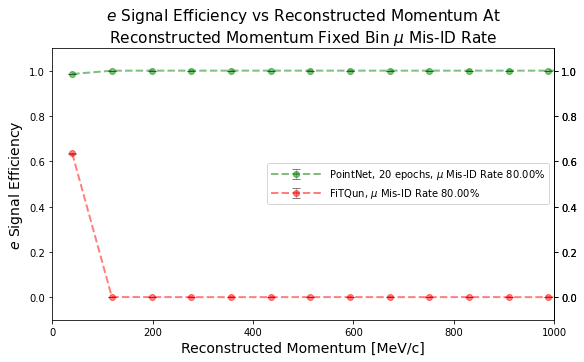

In [44]:
plot_momentum_binned_performance(reconstructed_momentum = fq_mom,
                                 scores_list            = scores_list, 
                                 labels_list            = labels_list, 
                                 fpr_fixed_point        = fpr_rate, 
                                 index_dict             = label_dict, 
                                 recons_mom_bin_size    = 50, 
                                 plot_bins              = 50,
                                 title_note             = '',
                                 yrange                 = [-0.1, 1.1],
                                 xrange                 = [0, 1000],
                                 names                  = names,
                                 colors                 = colors,
                                 desired_labels=['$e$','$\mu$']
                                )

../WatChMaL/analysis/performance_analysis_utils.py:129: RuntimeWarning: invalid value encountered in true_divide
  fprs = fps/(fps + tns)


Empty bin
Empty bin
Empty bin
Empty bin
Empty bin
Empty bin
Empty bin
Empty bin
Empty bin
Empty bin
Empty bin
Empty bin
Empty bin
Empty bin
Empty bin
Empty bin
Empty bin
Empty bin
Empty bin
Empty bin
Empty bin
Empty bin


<AxesSubplot:title={'center':'$e$ Signal Efficiency vs Energy At Reconstructed Momentum\nFixed Bin $\\mu$ Mis-ID Rate'}, xlabel='Energy [MeV/$c^2$]', ylabel='$e$ Signal Efficiency'>

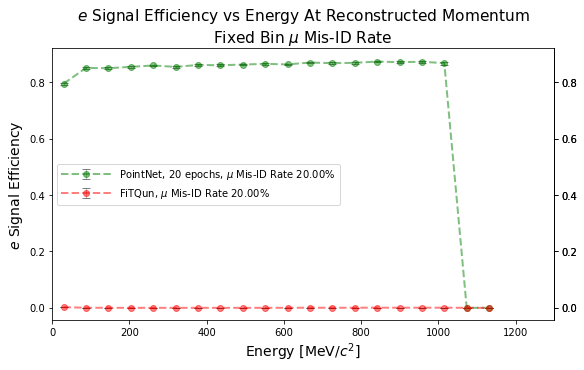

In [15]:
plot_energy_binned_performance(scores_list              = scores_list, 
                                 labels_list            = labels_list,
                                 reconstructed_momentum = fq_mom,
                                 energy_features        = test_energies,
                                 fpr_fixed_point        = 0.2, 
                                 index_dict             = label_dict, 
                                 recons_mom_bin_size    = 50, 
                                 plot_bins              = 20,
                                 title_note             = '',
                                 names                  = names,
                                 colors                 = colors,
                                 xrange                 = [0, 1300],
                                 desired_labels=['$e$','$\mu$']
                               )

../WatChMaL/analysis/performance_analysis_utils.py:129: RuntimeWarning: invalid value encountered in true_divide
  fprs = fps/(fps + tns)


Empty bin
Empty bin
Empty bin
Empty bin
Empty bin
Empty bin
Empty bin
Empty bin
Empty bin
Empty bin
Empty bin
Empty bin
Empty bin
Empty bin
Empty bin
Empty bin
Empty bin
Empty bin
Empty bin
Empty bin
Empty bin
Empty bin


<AxesSubplot:title={'center':'$e$ Signal Efficiency vs Zenith At Reconstructed Momentum\nFixed Bin $\\mu$ Mis-ID Rate'}, xlabel='Zenith [Radians]', ylabel='$e$ Signal Efficiency'>

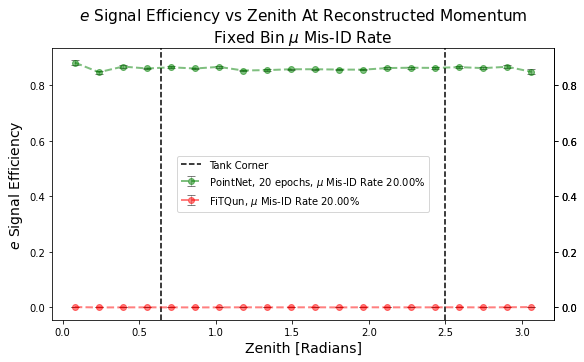

In [75]:
plot_zenith_binned_performance(scores_list              = scores_list, 
                                 labels_list            = labels_list,
                                 reconstructed_momentum = fq_mom,
                                 zenith_features        = test_zenith_angles,
                                 fpr_fixed_point        = 0.2, 
                                 index_dict             = label_dict, 
                                 recons_mom_bin_size    = 50, 
                                 plot_bins              = 20,
                                 title_note             = '',
                                 names                  = names,
                                 colors                 = colors,
                                 desired_labels         = ['$e$','$\mu$']
                               )

Empty bin
Empty bin
Empty bin
Empty bin
Empty bin
Empty bin
Empty bin
Empty bin
Empty bin
Empty bin
Empty bin
Empty bin
Empty bin
Empty bin
Empty bin
Empty bin
Empty bin
Empty bin
Empty bin
Empty bin
Empty bin
Empty bin
Empty bin
Empty bin


<AxesSubplot:title={'center':'$e$ Signal Efficiency vs Azimuth At Reconstructed Momentum\nFixed Bin $\\gamma$ Mis-ID Rate'}, xlabel='Azimuth [Radians]', ylabel='$e$ Signal Efficiency'>

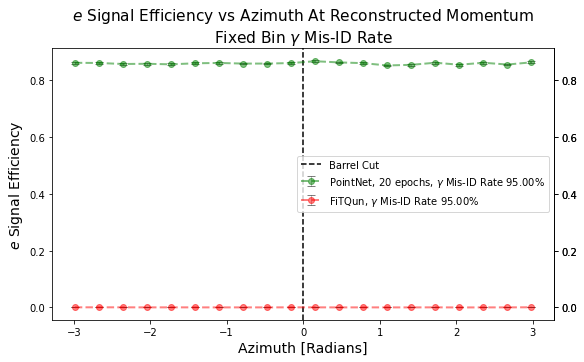

In [77]:
plot_azimuth_binned_performance(scores_list              = scores_list, 
                                 labels_list            = labels_list,
                                 reconstructed_momentum = fq_mom,  # need to calculate true mom as well
                                 azimuth_features       = test_azimuth_angles,
                                 fpr_fixed_point        = 0.95, #fpr_rate, 
                                 index_dict             = label_dict, 
                                 recons_mom_bin_size    = 50, 
                                 plot_bins              = 20,
                                 title_note             = '',
                                 names                  = names,
                                 colors                 = colors,
                                 desired_labels         = ['$e$','$\gamma$'],
                                 #yrange                 = [0.57, 0.73]
                               )

# FiTQun true vs reconstructed kinematics

In [15]:
fq_energies = fitqun_file['fq_energies']
# plt.plot(fq_energies[240000:246000], test_energies.flatten()[240000:246000], '.')
def f_e(x):
    return x
def f_mu(x):
    return x + 105
x = np.arange(105, 1105, 100)
# x = np.arange(0, 1000, 100)
y = f_mu(x)

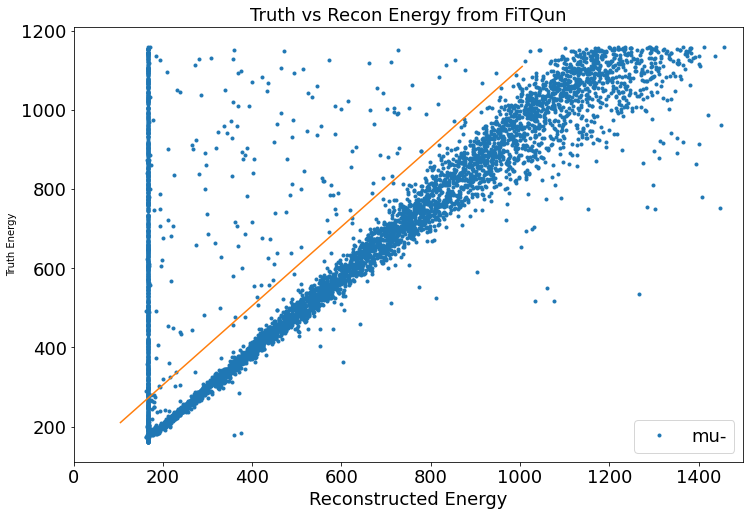

In [16]:
fig, ax = plt.subplots(1,1,figsize=(12,8))
ax.plot(fq_energies[240000:246000], test_energies.flatten()[240000:246000], '.', label='mu-')
ax.plot(x, y)

plt.xlim([0, 1500])
plt.xlabel('Reconstructed Energy', fontsize=18)
plt.ylabel('Truth Energy')
plt.xticks(fontsize=18)  # changing x-axis lable size
plt.yticks(fontsize=18)
plt.title('Truth vs Recon Energy from FiTQun', fontsize=18)
plt.legend(fontsize=18)
plt.show()

In [24]:
# Selecting all the events that fitqun reconstructed its momentum to 0
fq_mom_zero_evt_idx = np.where(fq_mom<5.)
print(len(fq_mom_zero_evt_idx[0]))
print(fq_mom)

4719
[743.2248  722.0323  567.5238  ... 399.42975 473.7832  251.68433]
